In [53]:
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.losses import mse
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import skimage
from random import shuffle

### Training and testing datasets 

In [67]:
normal = [1265, 1266, 1267, 1268, 1064, 1079, 1279, 1280, 1281, 1290, 1354, 1355, 1356, 1357, 1424, 1425, 1426, 1429, 1498, 1503, 1511, 1516, 1571, 1572, 1574, 1577, 1035, 1036, 1040, 1041, 805, 808, 812, 814] #+ [1153, 1197, 1228, 12429, 12575, 14241, 15595, 15649, 15665, 15707, 15801] # ultime Ra: [2.2, 2.5, ..., 0.22, 1, 1, 0.4, 0.5]
outliers = [1325, 1405, 6447, 7517, 7533, 7762, 8004, 8015, 8026, 8037, 8048, 8059, 8070, 8764, 8795, 8926, 8936, 1103, 11230, 11501, 11633, 12403, 12444, 12445, 12446, 12447, 12448, 12449, 12450, 12451, 12452, 12453, 12454, 12455, 12456, 12458, 12459, 12461, 12462, 12463, 12464, 12465, 12466, 12467, 1248, 12470, 12471, 12472, 12473, 12474, 12475, 12476, 12477, 12478, 1247, 12480, 12481, 12482, 12483, 12484, 12485, 12486, 12487, 12488, 12559, 12560, 12810, 12820, 12823, 12876, 12886, 12897, 12963, 14176, 15589, 15660, 15676, 15726, 15764, 16296, 16494, 17278, 17313, 17873, 17877, 17896, 18067, 18094, 18266, 18397, 18489]+list(range(12490, 12557))

normal = list(np.random.permutation(normal))
outliers = list(np.random.permutation(outliers))

normal_training = normal[0:len(normal)//3*2]
outliers_training = outliers[0:len(outliers)//3*2]
normal_testing = normal[len(normal)//3*2:]
outliers_testing = outliers[len(outliers)//3*2:]

def load_image(img_nr):
    if img_nr>9999:
        img=skimage.io.imread('Images/Original/0%d.png'%img_nr)
    elif img_nr<1000:
        img=skimage.io.imread('Images/Original/000%d.png'%img_nr)        
    else:
        img=skimage.io.imread('Images/Original/00%d.png'%img_nr)
    return img
len(normal_training), len(outliers_training), len(normal_testing), len(outliers_testing)

(22, 104, 12, 54)

### Preprocessing

In [68]:
size = 20
value = -1
im_shape = [480, 752]
vmax = 80

model = Sequential()
model.add(Convolution2D(1, size, use_bias=False, input_shape=(im_shape[0], im_shape[1], 1)))
model.add(MaxPooling2D(size, size))

W = model.layers[0].get_weights()
W[0].fill(value)
model.layers[0].set_weights(W)

def inner_loop(img_nr):
    img = load_image(img_nr)
    img = (img.astype('float32') / 255)-0.5
    heatmap = model.predict(img.reshape(1, img.shape[0], img.shape[1], 1)).reshape((im_shape[0]-size)//size, (im_shape[1]-size)//size)
    heatmap = np.abs(heatmap-np.mean(heatmap))
    return heatmap 
    
def compute_heatmaps():
    heatmaps = []
    for j in range(len(outliers)):
        heatmaps.append(inner_loop(outliers[j]))
    for j in range(len(normal)):
        heatmaps.append(inner_loop(normal[j]))
    return heatmaps 

heatmaps = compute_heatmaps() 

### Neural Network

In [69]:
heatmaps = np.asarray(heatmaps)
x = heatmaps/np.max(heatmaps)
y = np.concatenate([np.zeros((len(outliers))), np.ones((len(normal)))])

y_one=np.zeros((len(y), 2))
for i in range(len(y)):
    y_one[i,:]=np.eye(2)[(1+int(y[i]))%2]

indeces_training = list(range(len(outliers_training)))+list(range(len(x)-len(normal_testing), len(x)))
indeces_testing = list(range(len(outliers_training), len(outliers)))+list(range(len(outliers), len(outliers)+len(normal_testing)))

In [70]:
model = Sequential()
model.add(Flatten(input_shape=(23, 36)))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(x[indeces_testing], y_one[indeces_testing], epochs=50)

Epoch 1/50
66/66 [==============================] - 0s 7ms/step - loss: 0.1767 - acc: 0.7273
Epoch 2/50
66/66 [==============================] - 0s 128us/step - loss: 0.0997 - acc: 0.8182
Epoch 3/50
66/66 [==============================] - 0s 129us/step - loss: 0.0987 - acc: 0.8182
Epoch 4/50
66/66 [==============================] - 0s 441us/step - loss: 0.0938 - acc: 0.8182
Epoch 5/50
66/66 [==============================] - 0s 163us/step - loss: 0.0915 - acc: 0.8182
Epoch 6/50
66/66 [==============================] - 0s 204us/step - loss: 0.0893 - acc: 0.8182
Epoch 7/50
66/66 [==============================] - 0s 187us/step - loss: 0.0878 - acc: 0.8182
Epoch 8/50
66/66 [==============================] - 0s 178us/step - loss: 0.0872 - acc: 0.8182
Epoch 9/50
66/66 [==============================] - 0s 261us/step - loss: 0.0854 - acc: 0.8182
Epoch 10/50
66/66 [==============================] - 0s 234us/step - loss: 0.0826 - acc: 0.8182
Epoch 11/50
66/66 [==============================] 

### Plot Heatmaps

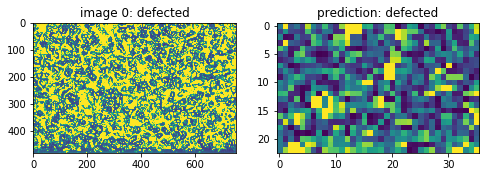

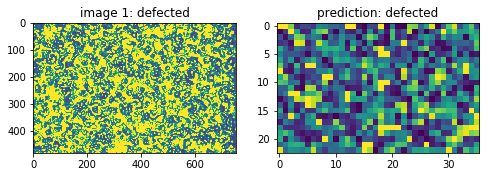

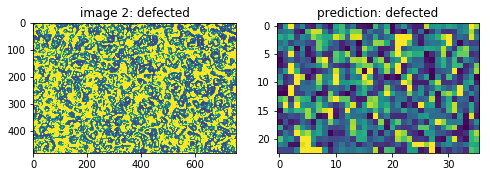

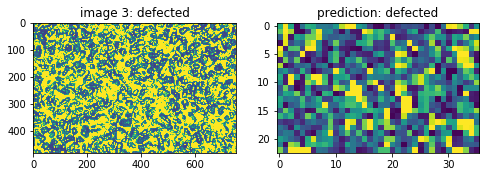

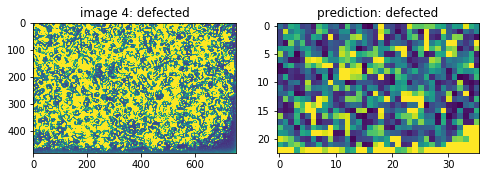

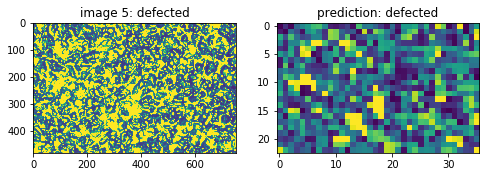

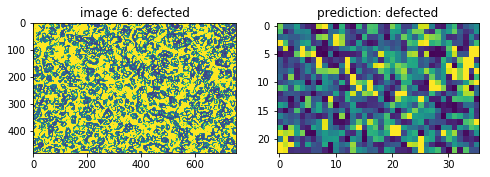

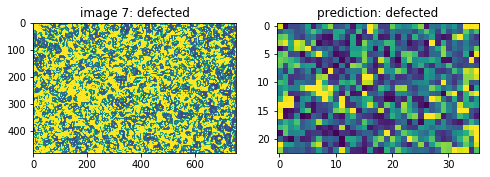

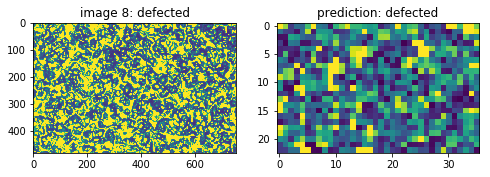

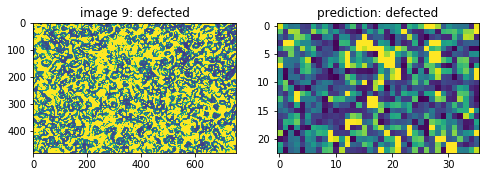

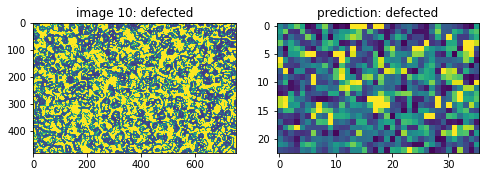

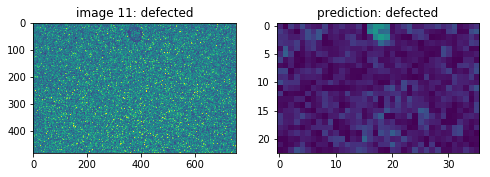

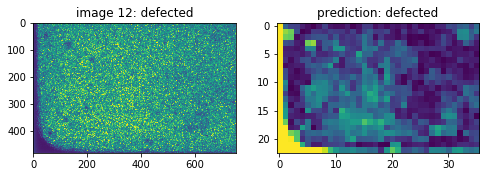

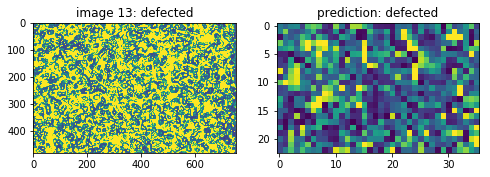

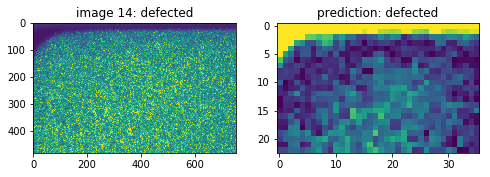

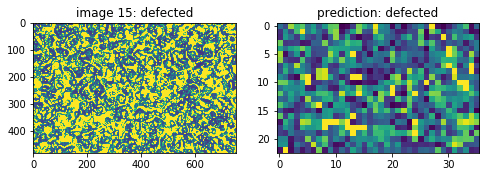

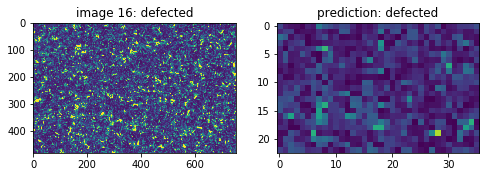

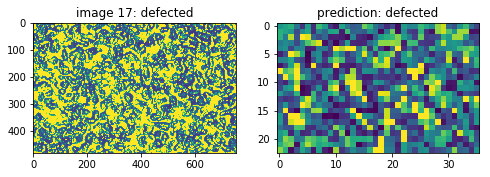

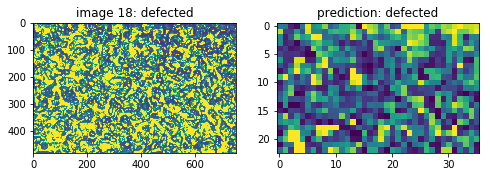

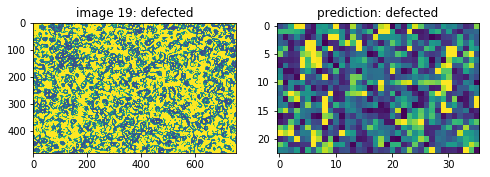

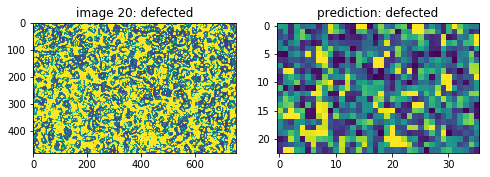

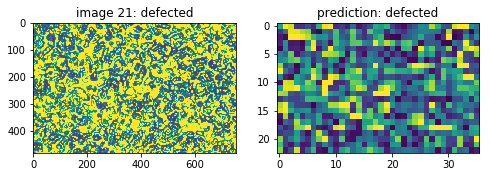

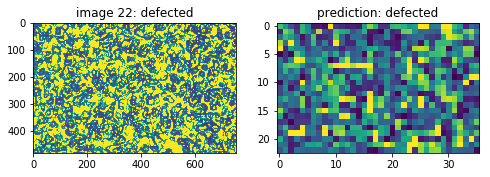

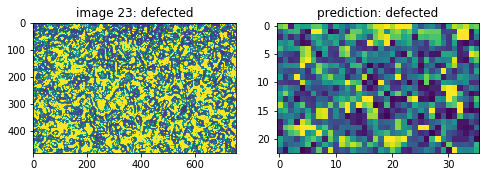

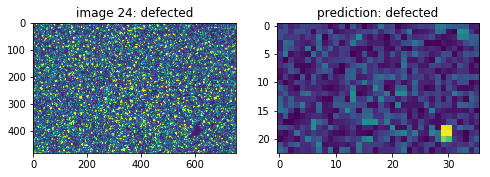

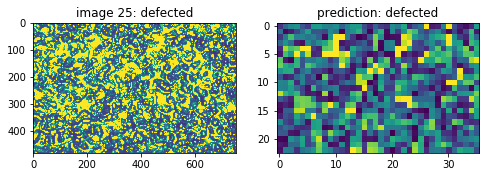

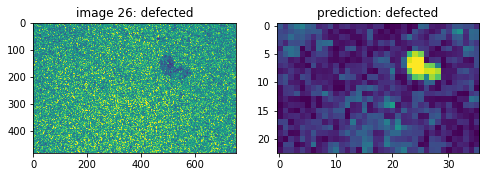

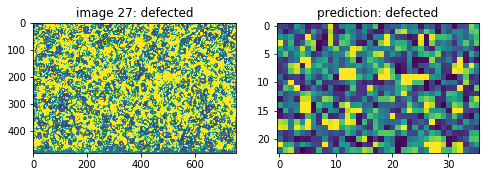

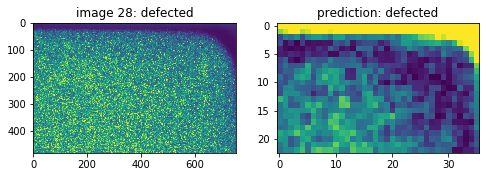

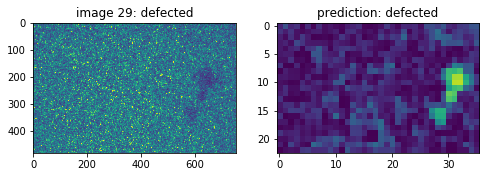

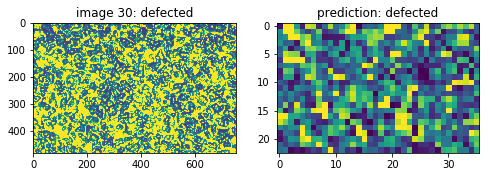

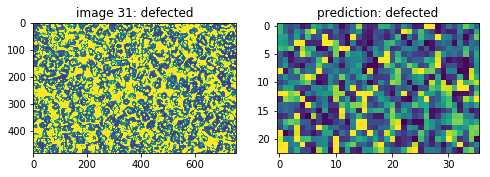

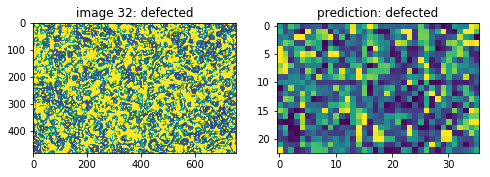

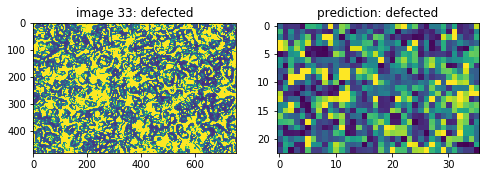

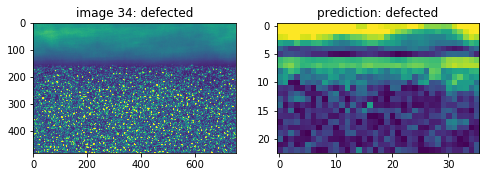

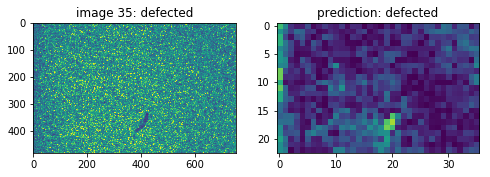

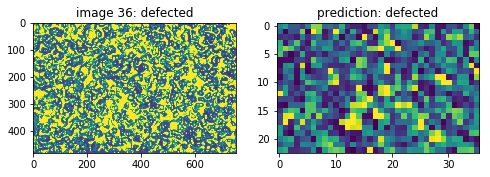

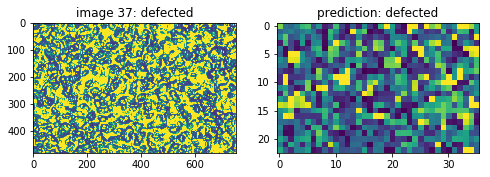

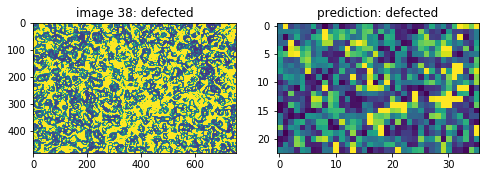

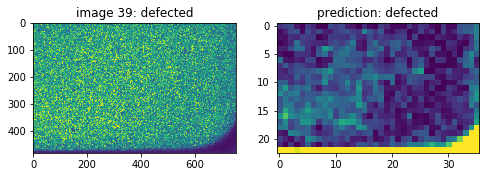

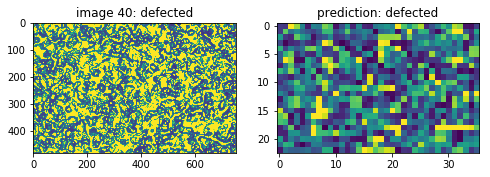

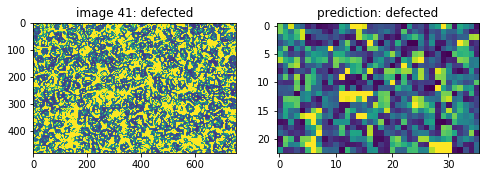

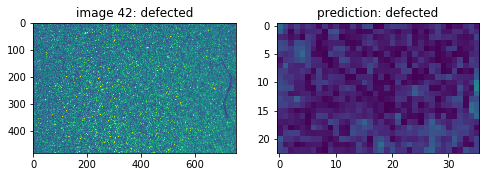

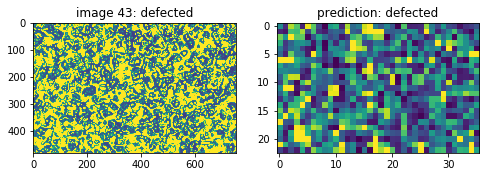

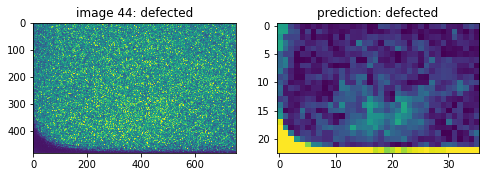

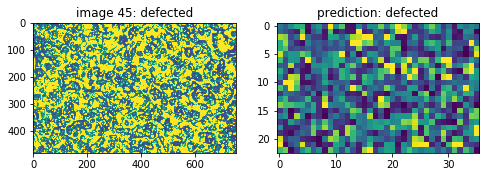

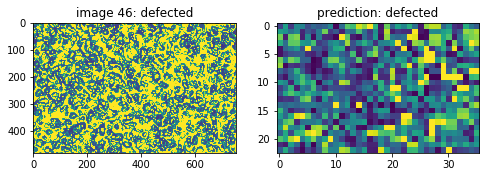

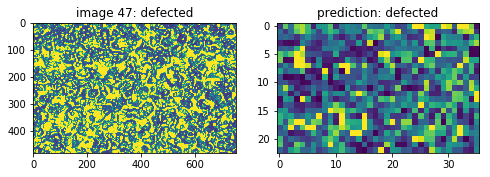

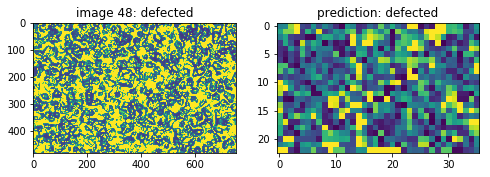

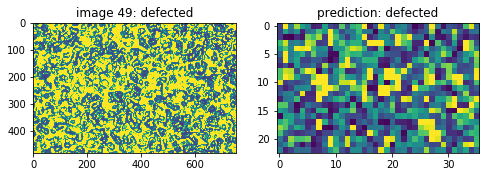

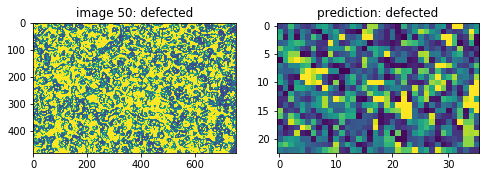

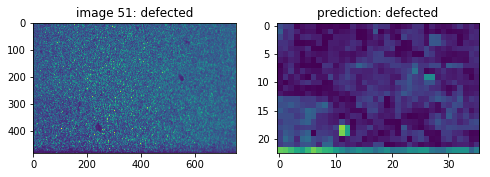

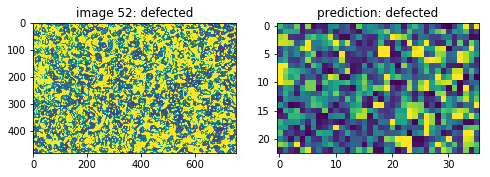

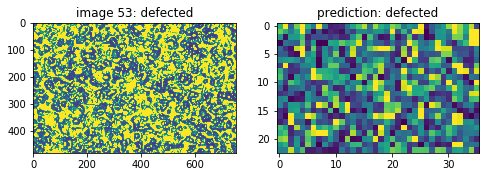

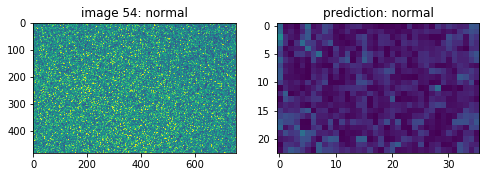

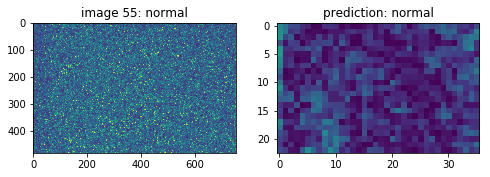

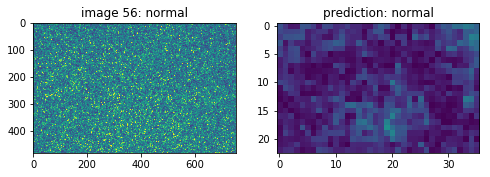

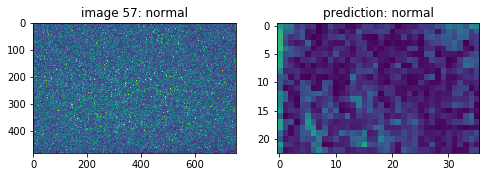

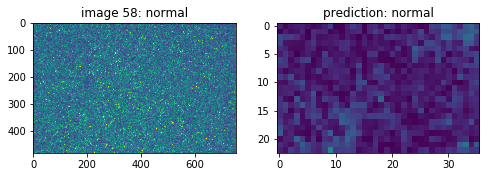

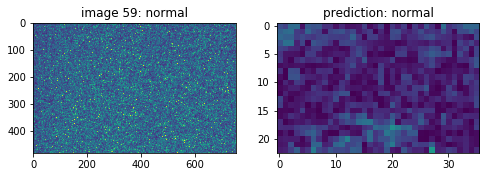

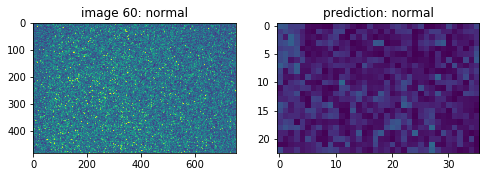

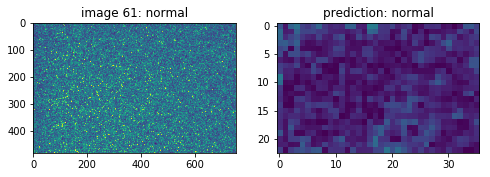

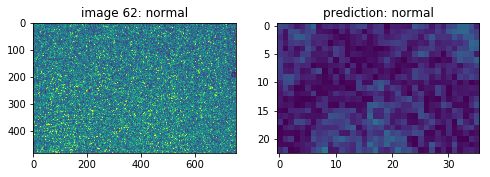

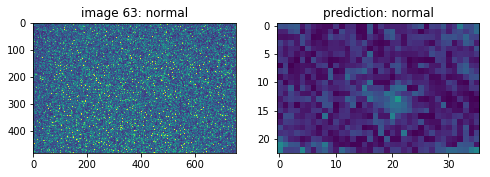

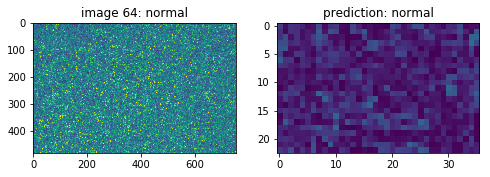

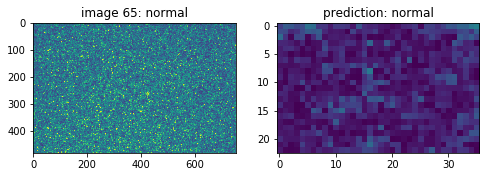

In [71]:
for i in range(len(x[indeces_testing])):
    title = ['defected', 'normal']
    plt.figure(figsize=(8, 4))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(load_image(np.concatenate([outliers_testing, normal_testing])[i]))
    plt.title('image %d: %s' %(i, title[int(y[indeces_testing][i])]))
    ax = plt.subplot(1, 2, 2)
    plt.imshow(heatmaps[indeces_testing][i].reshape(heatmaps.shape[1], heatmaps.shape[2]), vmin=0, vmax=vmax)
    plt.title('prediction: %s' %title[(1+np.argmax(model.predict(x[indeces_testing])[i]))%2])
    plt.show()

### Compute Performance

In [72]:
predictions = model.predict(x)[:,0]

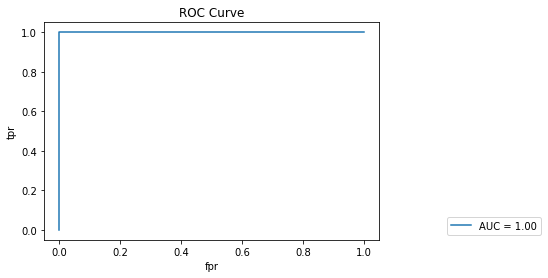

In [73]:
# ROC Curve
def plot_ROC():
    tpr = []
    fpr = []
    for threshold in np.arange(0,1, 0.01):
        tpr.append(len(np.where(predictions[indeces_testing][y[indeces_testing]==0]<threshold)[0])/len(outliers_testing))
        fpr.append(len(np.where(predictions[indeces_testing][y[indeces_testing]==1]<threshold)[0])/len(normal_testing))
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, label= 'AUC = %0.2f' % auc(fpr, tpr))
    plt.legend(loc = 4, bbox_to_anchor=(1.50, 0))
    plt.show()
    return fpr, tpr

fpr, tpr = plot_ROC()